# Importamos las librerias

In [25]:
import os
import shutil
import numpy as np
import itertools
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

# Rutas de las carpetas

In [2]:
base_path = r"\Users\chech\IdeaProjects\proyecto grado"
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
real_dir = os.path.join(base_path, 'REAL')

# Parámetros 

In [3]:
img_height, img_width = 150, 150
batch_size = 32
epochs = 15

# Preparar generadores de flujo de datos

In [4]:
# Crear generadores de datos
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255  # Escalar píxeles al rango [0, 1]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de datos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Especificar el modo de color como blanco y negro
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Especificar el modo de color como blanco y negro
)

Found 955 images belonging to 3 classes.
Found 435 images belonging to 3 classes.


# Definición del modelo

In [5]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

C:\Users\chech\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# compilar el modelo

In [6]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      37,880,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,251,523 (145.92 MB)

 Trainable params: 38,251,523 (145.92 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [7]:
## Configurar callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/15


C:\Users\chech\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3631 - loss: 2.0922 - val_accuracy: 0.3333 - val_loss: 1.1181
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3467 - loss: 1.0996 - val_accuracy: 0.3333 - val_loss: 1.0998
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3588 - loss: 1.0973 - val_accuracy: 0.3333 - val_loss: 1.0958
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3567 - loss: 1.0955 - val_accuracy: 0.3149 - val_loss: 1.0888
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3832 - loss: 1.0856 - val_accuracy: 0.3333 - val_loss: 1.1120
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3687 - loss: 1.0740 - val_accuracy: 0.5839 - val_loss: 1.0104
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4906 - loss: 0.9500 - val_accuracy: 0.3747 - val_loss: 1.2112
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5349 - loss: 0.9247 - val_accuracy: 0.3908 - val_loss: 1.1760
Epo

# Cargar el modelo

In [ ]:
model_file = '\\Users\\chech\\IdeaProjects\\proyecto grado\\best_model.keras'
best_model = load_model(model_file)

# Evaluación del modelo

In [9]:
y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step


# Visualizar curvas de precisión y pérdida para detectar el overfitting

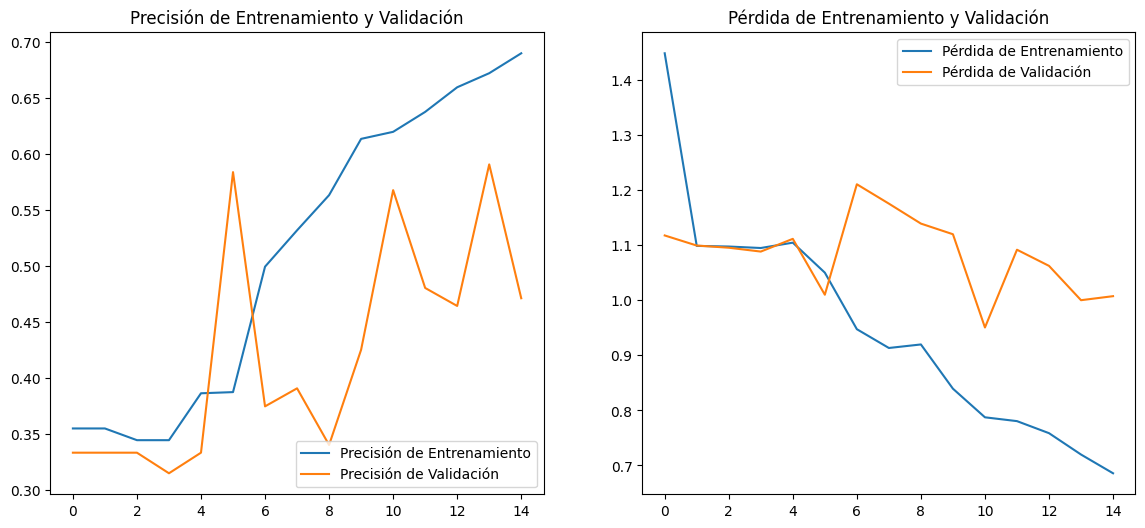

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()

# Matriz de confusión

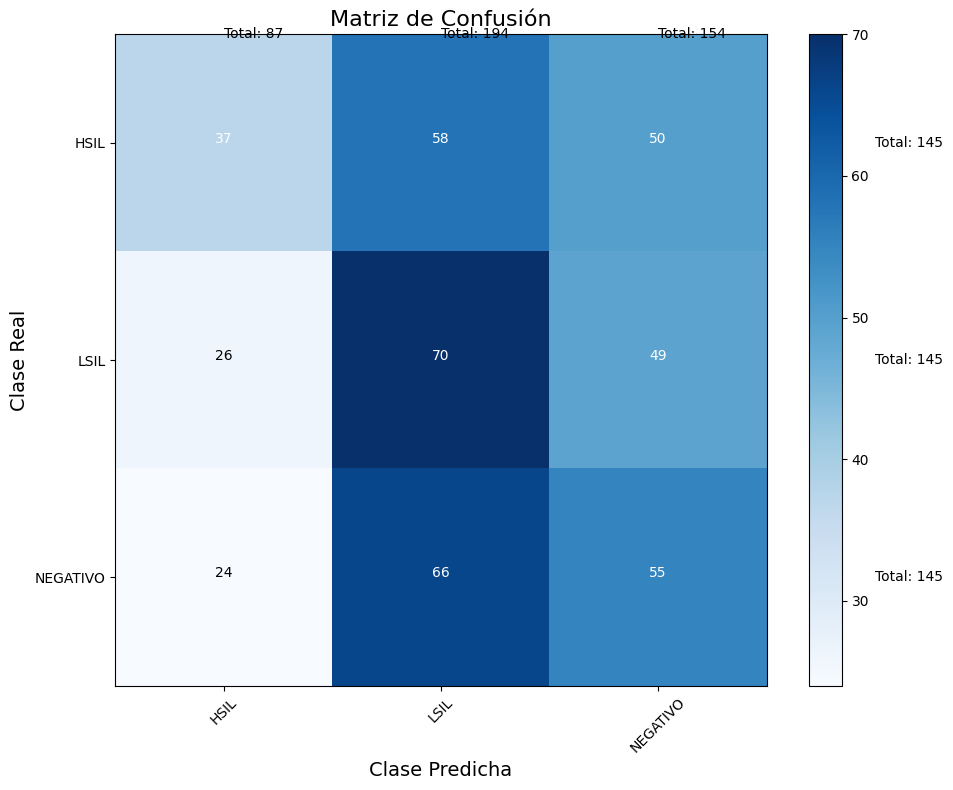

In [11]:
cm = confusion_matrix(y_true, y_pred)
target_names = ['HSIL', 'LSIL', 'NEGATIVO']
total_predicciones_clase = np.sum(cm, axis=1)
total_predicciones_clase_predicha = np.sum(cm, axis=0)

# Gráfica de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.xlabel('Clase Predicha', fontsize=14)
plt.ylabel('Clase Real', fontsize=14)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Añadir números totales de predicciones para cada clase
for i in range(len(target_names)):
    plt.text(len(target_names), i, f'Total: {total_predicciones_clase[i]}', verticalalignment='center')
    plt.text(i, -0.5, f'Total: {total_predicciones_clase_predicha[i]}', verticalalignment='center')

plt.tight_layout()
plt.show()

# Reporte de clasificación

Classification Report
              precision    recall  f1-score   support

        HSIL       0.43      0.26      0.32       145
        LSIL       0.36      0.48      0.41       145
    NEGATIVO       0.36      0.38      0.37       145

    accuracy                           0.37       435
   macro avg       0.38      0.37      0.37       435
weighted avg       0.38      0.37      0.37       435



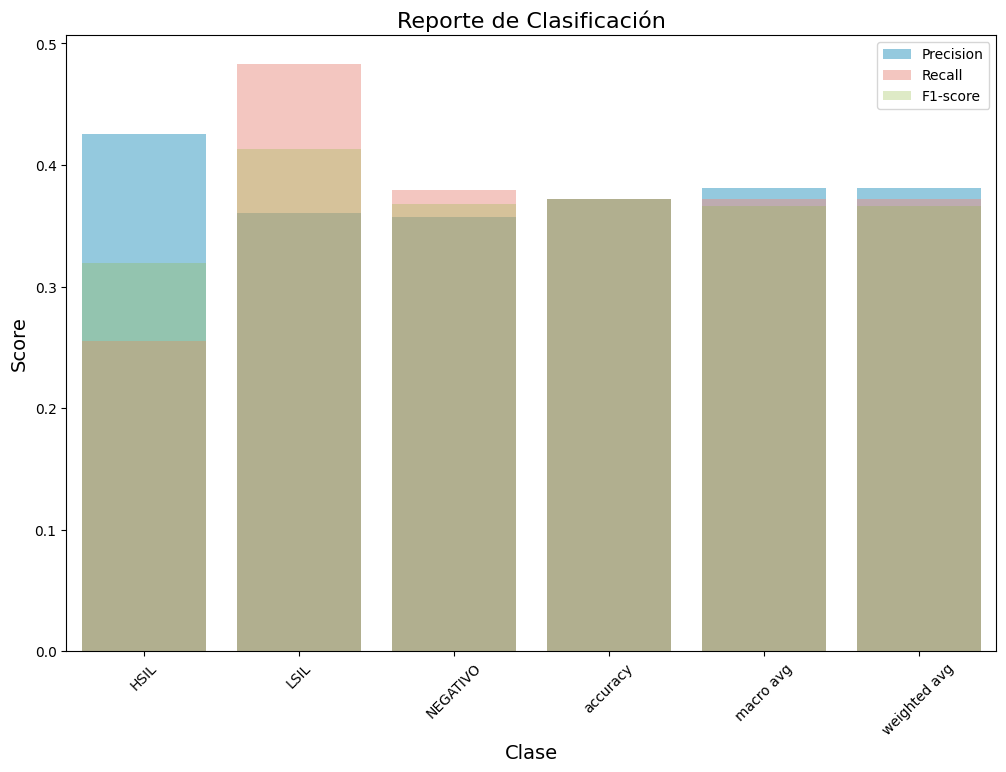

In [12]:
# Reporte de clasificación
print("Classification Report")
target_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Gráfica del reporte de clasificación
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 8))
sns.barplot(x=df_report.index, y=df_report['precision'], color='skyblue', label='Precision')
sns.barplot(x=df_report.index, y=df_report['recall'], color='salmon', label='Recall', alpha=0.5)
sns.barplot(x=df_report.index, y=df_report['f1-score'], color='yellowgreen', label='F1-score', alpha=0.3)
plt.title('Reporte de Clasificación', fontsize=16)
plt.xlabel('Clase', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Curva ROC y AUC

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=3)[:, i], y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Gráfica de la curva ROC

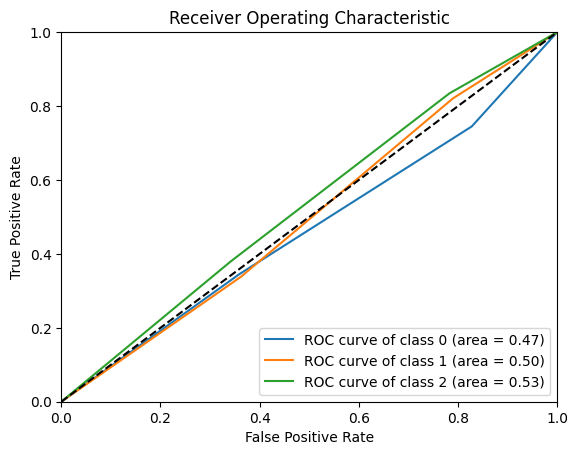

In [20]:

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()